In [1]:
# Exploration
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

# Model Implementation
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

__Methodology:__
1. Data Exploration and Preprocessing: We start by exploring the provided dataset, gaining a deep understanding of the available features, their relationships, and potential challenges. Through careful preprocessing, we handle missing values, encode categorical variables, and prepare the data for further analysis.

2. Exploratory Data Analysis (EDA): Armed with a rich dataset, we embark on an exploratory journey to uncover hidden patterns, trends, and correlations. Engaging visualizations and statistical techniques help us understand the key factors influencing sales, detect seasonal variations, and identify any intriguing trends that may influence business decisions.

3. Time Series Analysis: Equipped with a solid foundation from EDA, we employ time series analysis techniques to capture the temporal patterns within the sales data. Leveraging the power of models like ARIMA (Autoregressive Integrated Moving Average), we aim to build a forecasting model that can capture the complex dynamics of retail sales.

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./train.csv')
stores = pd.read_csv('./stores.csv')
features = pd.read_csv('./features.csv')

### __Data Exploration__

In [3]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [5]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [6]:
display(stores.head())
print('\n')
display(stores.info())

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

In [7]:
print('Missing Values: ')
print(train.isnull().sum())

Missing Values: 
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [8]:
display(features.head())
display(features.info())

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


None

##### __Explore Unique Values__

In [9]:
# Explore unique values in categorical variables
print('\nUnique Store Types: ')
print(stores['Type'].unique())


Unique Store Types: 
['A' 'B' 'C']


In [10]:
print('\nUnique Store Types: ')
print(train['Dept'].sort_values(ascending=True).unique())


Unique Store Types: 
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 58 59 60 65 67 71 72 74 77 78 79 80 81 82 83 85 87 90
 91 92 93 94 95 96 97 98 99]


In [11]:
print('\nUnique Holidays: ')
print(train['IsHoliday'].unique())


Unique Holidays: 
[False  True]


### __Feature Engineering__
1. Combining store and department information: The 'Store' and 'Dept' columns are combined into a new column called 'Store_Dept' by concatenating their values as strings. This allows for better representation of the relationship between store and department in the dataset.

2. Extracting month and year from the Date column: The 'Date' column is parsed into separate columns for month and year. This allows for easier analysis and grouping of data based on these time components.

3. Calculating the total markdown amount: The individual 'MarkDown' columns are used to calculate the total markdown amount for each record. This aggregation provides a consolidated view of the promotional markdowns for a specific store and department.

4. Encoding categorical variables: Categorical variables, such as the 'IsHoliday' column, are encoded to numerical format. In the example provided, the 'IsHoliday' column is converted to integer values (0 for False and 1 for True). This enables the use of these variables in machine learning algorithms that require numeric input.

5. Merging additional features to the train and test datasets: The 'stores' and 'features' datasets are merged with the train and test datasets based on the common columns 'Store' and 'Date'. This combines the relevant additional information (such as store type, size, temperature, fuel price, etc.) with the corresponding records in the train and test datasets.

In [12]:
# Combine store and department information
train['Store_Dept'] = train['Store'].astype(str) + '_' + train['Dept'].astype(str)
test['Store_Dept'] = test['Store'].astype(str) + '_' + test['Dept'].astype(str)

In [13]:
# Extract month and year from the Date Column
train['Month'] = pd.to_datetime(train['Date']).dt.month
train['Year'] = pd.to_datetime(train['Date']).dt.year

test['Month'] = pd.to_datetime(test['Date']).dt.month
test['Year'] = pd.to_datetime(test['Date']).dt.year

features['Month'] = pd.to_datetime(features['Date']).dt.month
features['Year'] = pd.to_datetime(features['Date']).dt.year

In [14]:
# Calculate the total markdown amount
features['Total_Markdown'] =\
    features['MarkDown1'] +\
        features['MarkDown2'] +\
            features['MarkDown3'] + \
                features['MarkDown4'] +\
                    features['MarkDown5']

In [15]:
# Encode categorical variables
# Example: One-hot encoding for store types
store_type_dummies = pd.get_dummies(stores['Type'], prefix='Store_Type', drop_first=True, dtype='int64')
stores = pd.concat([stores, store_type_dummies], axis=1)

In [16]:
# Merge additional features to the train an test datasets
train = train.merge(stores, on='Store', how='left')
train = train.merge(features, on=['Store', 'Date'], how='left')

test = test.merge(stores, on='Store', how='left')
test = test.merge(features, on=['Store', 'Date'], how='left')

In [17]:
print('Train')
display(train.head())
print('Test')
display(test.head())

Train


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Total_Markdown
0,1,1,2010-02-05,24924.50,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,2010,NaN
1,1,1,2010-02-12,46039.49,True,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.242170,8.106,True,2,2010,NaN
2,1,1,2010-02-19,41595.55,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.289143,8.106,False,2,2010,NaN
3,1,1,2010-02-26,19403.54,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.319643,8.106,False,2,2010,NaN
4,1,1,2010-03-05,21827.90,False,1_1,3,2010,A,151315,...,NaN,NaN,NaN,NaN,211.350143,8.106,False,3,2010,NaN


Test


,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Total_Markdown
0,1,1,2010-02-05,24924.50,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,2010,NaN
1,1,1,2010-02-12,46039.49,True,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.242170,8.106,True,2,2010,NaN
2,1,1,2010-02-19,41595.55,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.289143,8.106,False,2,2010,NaN
3,1,1,2010-02-26,19403.54,False,1_1,2,2010,A,151315,...,NaN,NaN,NaN,NaN,211.319643,8.106,False,2,2010,NaN
4,1,1,2010-03-05,21827.90,False,1_1,3,2010,A,151315,...,NaN,NaN,NaN,NaN,211.350143,8.106,False,3,2010,NaN


__Some Additional Features__
1. Lag Features: Create lag features by shifting the target variable (Weekly_Sales) for a specific time period. This can capture the trend and seasonality in the data.

2. Rolling Statistics: Calculate rolling statistics such as rolling mean, rolling standard deviation, or rolling sum for the target variable and other relevant features. This can capture the moving average or moving sum over a specific window size.

3. Holiday Features: Create binary indicators for specific holidays, indicating whether a given week falls within a holiday period or not.

4. Seasonal Features: Extract seasonal information such as month, quarter, or week of the year, which can help capture recurring patterns.

In [18]:
# Create lag features
train['Weekly_Sales_Lag1'] = train['Weekly_Sales'].shift(1)
train['Weekly_Sales_Lag2'] = train['Weekly_Sales'].shift(2)

In [19]:
# Create Rolling Statistics
train['Rolling_Mean'] = train['Weekly_Sales'].rolling(window=4).mean()
train['Rolling_Median'] = train['Weekly_Sales'].rolling(window=4).std()

In [20]:
# Convert Date column to datetime type
train['Date'] = pd.to_datetime(train['Date'])

# Create seasonal features
train['Month'] = train['Date'].dt.month
train['Quarter'] = train['Date'].dt.quarter
train['WeekOfYear'] = train['Date'].dt.isocalendar().week

In [21]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,Month_y,Year_y,Total_Markdown,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Rolling_Mean,Rolling_Median,Month,Quarter,WeekOfYear
0,1,1,2010-02-05,24924.50,False,1_1,2,2010,A,151315,...,2,2010,NaN,NaN,NaN,NaN,NaN,2,1,5
1,1,1,2010-02-12,46039.49,True,1_1,2,2010,A,151315,...,2,2010,NaN,24924.50,NaN,NaN,NaN,2,1,6
2,1,1,2010-02-19,41595.55,False,1_1,2,2010,A,151315,...,2,2010,NaN,46039.49,24924.50,NaN,NaN,2,1,7
3,1,1,2010-02-26,19403.54,False,1_1,2,2010,A,151315,...,2,2010,NaN,41595.55,46039.49,32990.7700,12832.106391,2,1,8
4,1,1,2010-03-05,21827.90,False,1_1,3,2010,A,151315,...,3,2010,NaN,19403.54,41595.55,32216.6200,13554.047185,3,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,45_98,9,2012,B,118221,...,9,2012,9468.01,467.30,605.96,483.5175,104.966868,9,3,39
421566,45,98,2012-10-05,628.10,False,45_98,10,2012,B,118221,...,10,2012,NaN,508.37,467.30,552.4325,76.984435,10,4,40
421567,45,98,2012-10-12,1061.02,False,45_98,10,2012,B,118221,...,10,2012,NaN,628.10,508.37,666.1975,271.910500,10,4,41
421568,45,98,2012-10-19,760.01,False,45_98,10,2012,B,118221,...,10,2012,NaN,1061.02,628.10,739.3750,237.786139,10,4,42


### __Data Transformation__
1. Conversion of 'Date' column: The 'Date' column in the train, test, and features datasets is converted from a string format to a datetime format using the pd.to_datetime() function.

2. Sorting by 'Date': The datasets are sorted in ascending order based on the 'Date' column to ensure that the data is arranged chronologically.

3. Setting 'Date' as the index: The 'Date' column is set as the index of the train, test, and features datasets using the set_index() method. This allows for easy indexing and time-based operations.

4. Handling missing values: Any missing values in the datasets are filled with 0 using the fillna() method. This ensures that all cells have a valid value and prevents issues during analysis.

5. Resetting the index: The index of the train, test, and features datasets is reset using the reset_index() method. This restores the 'Date' column as a regular column and provides a sequential index for the data.

In [22]:
# Convert the Date column to datetime format
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [23]:
# Sort the datasets by `Date`
train = train.sort_values('Date')
test = test.sort_values('Date')
features = features.sort_values('Date')

In [24]:
# Set `Date` as the index
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
features.set_index('Date', inplace=True)

# Fill missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)
features.fillna(0, inplace=True)

# Reset Index
train.reset_index(inplace=True)
test.reset_index(inplace=True)
features.reset_index(inplace=True)

In [25]:
features

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,Year,Total_Markdown
0,2010-02-05,1,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,False,2,2010,0.00
1,2010-02-05,16,19.79,2.580,0.00,0.00,0.00,0.00,0.00,189.381697,7.039,False,2,2010,0.00
2,2010-02-05,31,39.05,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,False,2,2010,0.00
3,2010-02-05,21,39.05,2.572,0.00,0.00,0.00,0.00,0.00,210.752605,8.324,False,2,2010,0.00
4,2010-02-05,26,9.55,2.788,0.00,0.00,0.00,0.00,0.00,131.527903,8.488,False,2,2010,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,2013-07-26,32,72.99,3.582,549.89,940.93,86.00,106.47,1530.56,0.000000,0.000,False,7,2013,3213.85
8186,2013-07-26,13,83.62,3.669,346.31,1377.41,93.40,140.32,2147.06,0.000000,0.000,False,7,2013,4104.50
8187,2013-07-26,31,85.00,3.620,1394.82,138.71,12.00,970.77,6859.07,0.000000,0.000,False,7,2013,9375.37
8188,2013-07-26,37,83.28,3.620,178.00,11.86,0.00,0.00,779.32,0.000000,0.000,False,7,2013,0.00


### __Exploratory Data Analysis__

In [26]:
print('Stores column: ')
print(stores.columns)

print('\nTrain columns: ')
print(train.columns)

print('\nFeatures columns: ')
print(features.columns)

Stores column: 
Index(['Store', 'Type', 'Size', 'Store_Type_B', 'Store_Type_C'], dtype='object')

Train columns: 
Index(['Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday_x', 'Store_Dept',
       'Month_x', 'Year_x', 'Type', 'Size', 'Store_Type_B', 'Store_Type_C',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y',
       'Month_y', 'Year_y', 'Total_Markdown', 'Weekly_Sales_Lag1',
       'Weekly_Sales_Lag2', 'Rolling_Mean', 'Rolling_Median', 'Month',
       'Quarter', 'WeekOfYear'],
      dtype='object')

Features columns: 
Index(['Date', 'Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Month', 'Year', 'Total_Markdown'],
      dtype='object')


In [27]:
display(train.head())
display(test.head())
display(features.head())
display(stores.head())

,Date,Store,Dept,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,Month_y,Year_y,Total_Markdown,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Rolling_Mean,Rolling_Median,Month,Quarter,WeekOfYear
0,2010-02-05,1,1,24924.50,False,1_1,2,2010,A,151315,...,2,2010,0.0,0.00,0.00,0.0000,0.000000,2,1,5
1,2010-02-05,29,5,15552.08,False,29_5,2,2010,B,93638,...,2,2010,0.0,16512.89,15520.36,15721.8300,538.964060,2,1,5
2,2010-02-05,29,6,3200.22,False,29_6,2,2010,B,93638,...,2,2010,0.0,10328.06,17657.20,10061.1675,5939.907431,2,1,5
3,2010-02-05,29,7,10820.05,False,29_7,2,2010,B,93638,...,2,2010,0.0,1062.59,1356.70,3806.6575,4691.480600,2,1,5
4,2010-02-05,29,8,20055.64,False,29_8,2,2010,B,93638,...,2,2010,0.0,11260.30,13066.83,14640.0725,3805.271794,2,1,5


,Date,Store,Dept,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Month_y,Year_y,Total_Markdown
0,2010-02-05,1,1,24924.50,False,1_1,2,2010,A,151315,...,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,2010,0.0
1,2010-02-05,29,5,15552.08,False,29_5,2,2010,B,93638,...,0.0,0.0,0.0,0.0,131.527903,10.064,False,2,2010,0.0
2,2010-02-05,29,6,3200.22,False,29_6,2,2010,B,93638,...,0.0,0.0,0.0,0.0,131.527903,10.064,False,2,2010,0.0
3,2010-02-05,29,7,10820.05,False,29_7,2,2010,B,93638,...,0.0,0.0,0.0,0.0,131.527903,10.064,False,2,2010,0.0
4,2010-02-05,29,8,20055.64,False,29_8,2,2010,B,93638,...,0.0,0.0,0.0,0.0,131.527903,10.064,False,2,2010,0.0


,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Month,Year,Total_Markdown
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,2010,0.0
1,2010-02-05,16,19.79,2.580,0.0,0.0,0.0,0.0,0.0,189.381697,7.039,False,2,2010,0.0
2,2010-02-05,31,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,False,2,2010,0.0
3,2010-02-05,21,39.05,2.572,0.0,0.0,0.0,0.0,0.0,210.752605,8.324,False,2,2010,0.0
4,2010-02-05,26,9.55,2.788,0.0,0.0,0.0,0.0,0.0,131.527903,8.488,False,2,2010,0.0


,Store,Type,Size,Store_Type_B,Store_Type_C
0,1,A,151315,0,0
1,2,A,202307,0,0
2,3,B,37392,1,0
3,4,A,205863,0,0
4,5,B,34875,1,0


### __EDA Stores__

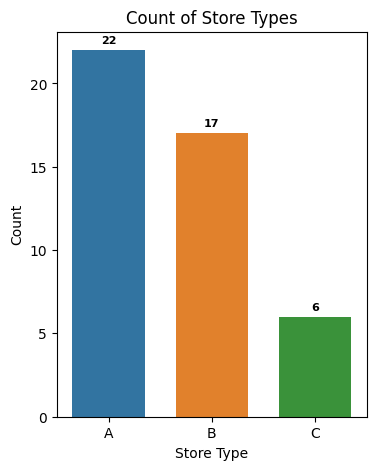

In [28]:
# Countplot of stores types
plt.figure(figsize=(4,5))
ax = sns.countplot(data=stores, x='Type',width=.7)
plt.title('Count of Store Types')
plt.xlabel('Store Type')
plt.ylabel('Count')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, fontweight='bold',color='black', xytext=(0,7),
                textcoords='offset points')
plt.show()

C:\Users\MG GAMING PRO.DESKTOP-3QJQCSQ\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


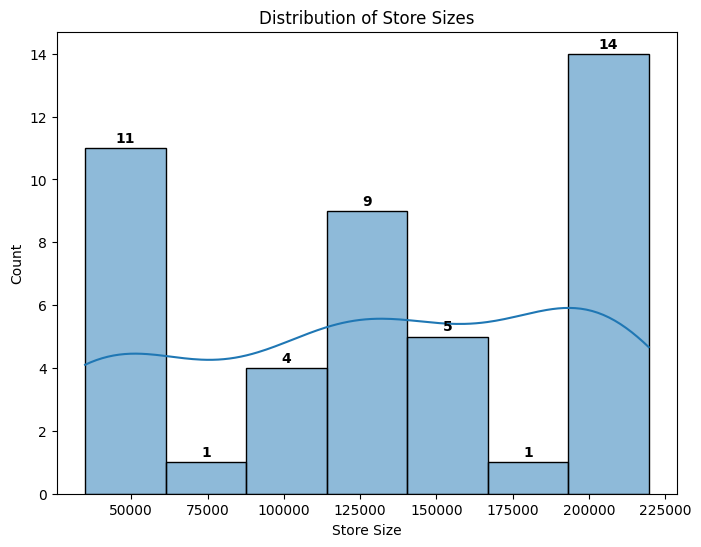

In [29]:
# Distribution of store sizes
plt.figure(figsize=(8,6))
ax = sns.histplot(data=stores, x='Size', kde=True)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, fontweight='bold',color='black', xytext=(0,7),
                textcoords='offset points')

plt.title('Distribution of Store Sizes')
plt.xlabel('Store Size')
plt.ylabel('Count')
plt.show()

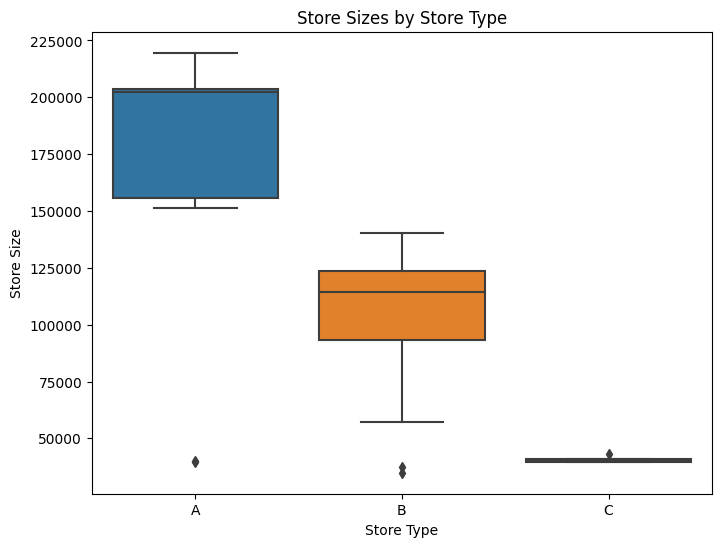

In [30]:
# Boxplot if Store sizes by store type
plt.figure(figsize=(8,6))
sns.boxplot(data=stores, x='Type', y='Size')
plt.title('Store Sizes by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Store Size')
plt.show()

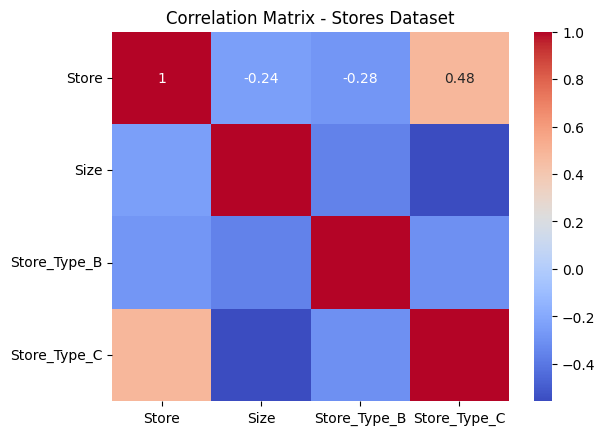

In [41]:
# Corr matrix
corr_matrix = stores.drop(columns='Type')
corr_matrix = corr_matrix.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Stores Dataset')
plt.show()

In [32]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Store         45 non-null     int64 
 1   Type          45 non-null     object
 2   Size          45 non-null     int64 
 3   Store_Type_B  45 non-null     int64 
 4   Store_Type_C  45 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ KB


C:\Users\MG GAMING PRO.DESKTOP-3QJQCSQ\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


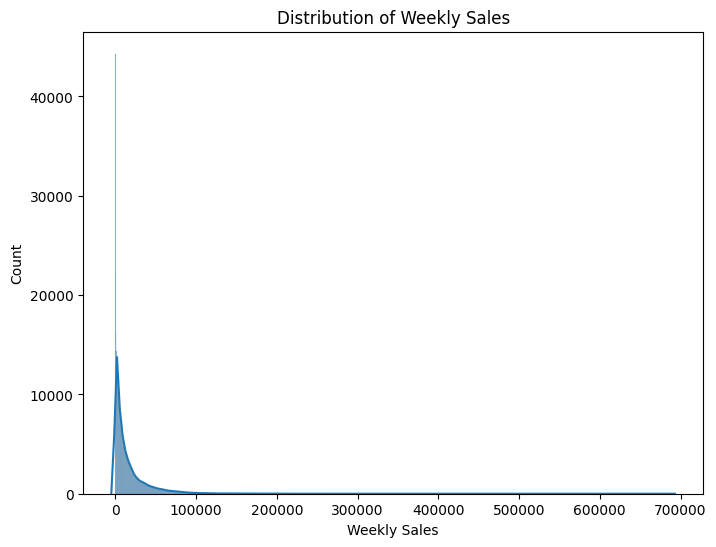

In [33]:
# Distribution of weekly sales
plt.figure(figsize=(8,6))
sns.histplot(data=train, x='Weekly_Sales', kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Count')
plt.show()

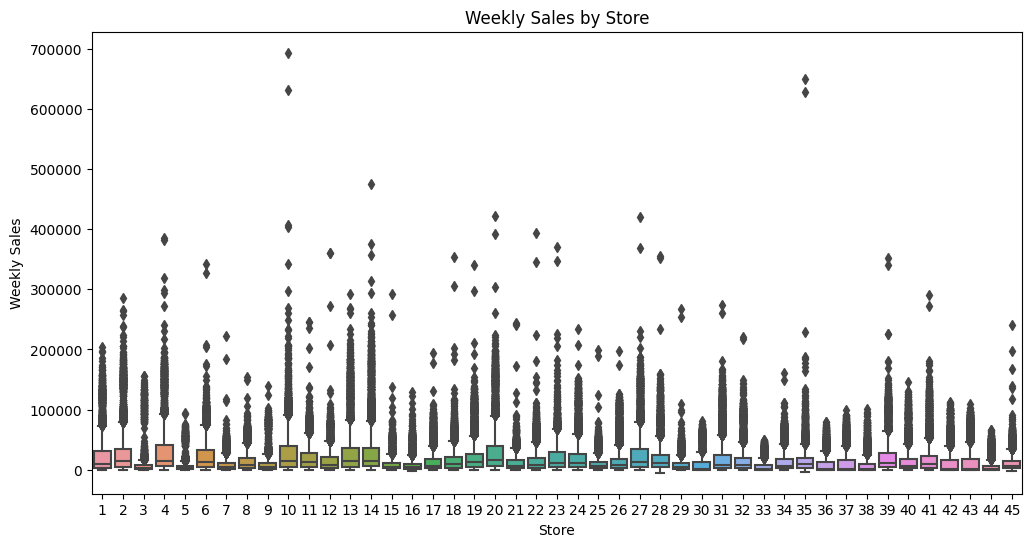

In [42]:
# Boxplot of Weekly sales by Store
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='Store', y='Weekly_Sales')
plt.title('Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

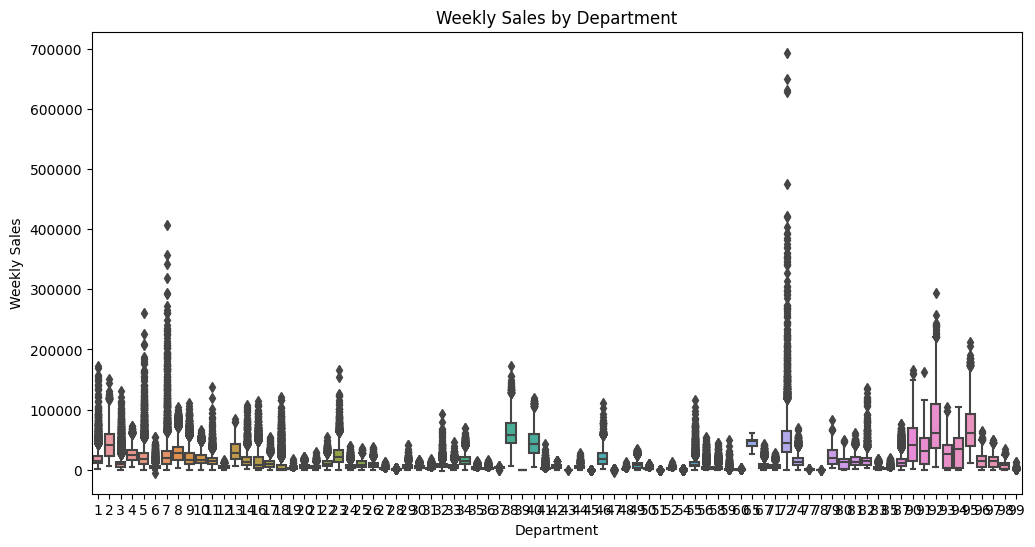

In [44]:
# Boxplot of Weekly sales by Department
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='Dept', y='Weekly_Sales')
plt.title('Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Weekly Sales')
plt.show()

C:\Users\MG GAMING PRO.DESKTOP-3QJQCSQ\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MG GAMING PRO.DESKTOP-3QJQCSQ\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


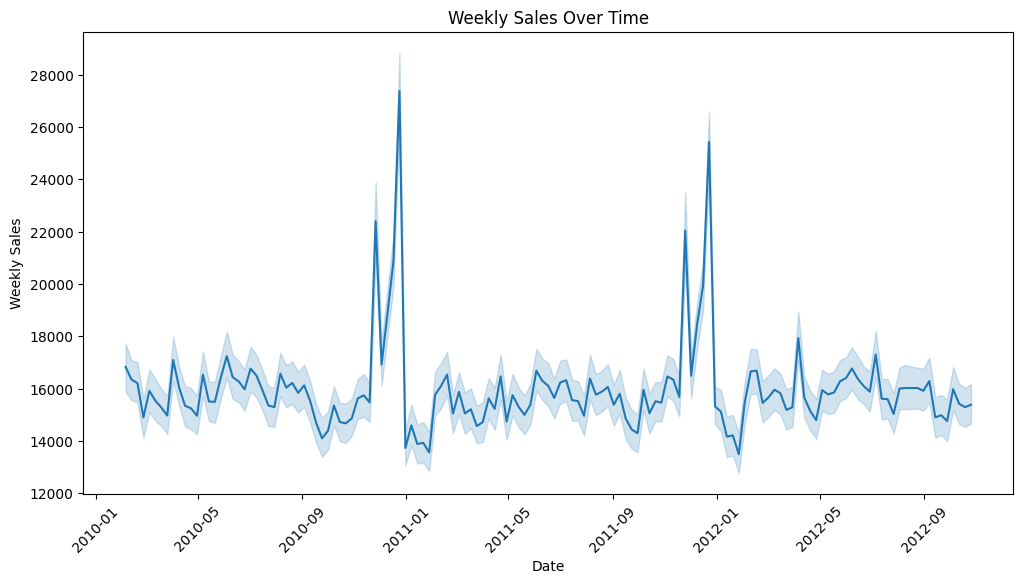

In [45]:
# Line plot of Weekly Sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x='Date', y='Weekly_Sales')
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.show()

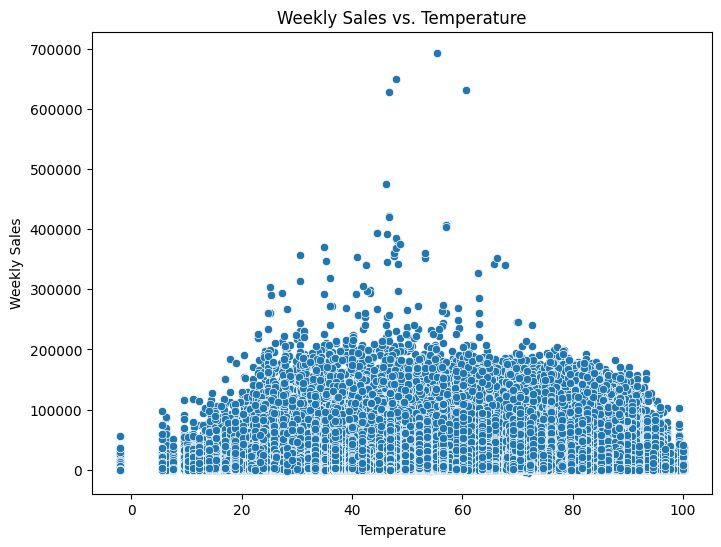

In [47]:
# Scatter plot of weekly sales vs. temperature
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train, x='Temperature', y='Weekly_Sales')
plt.title('Weekly Sales vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

In [53]:
# Correlation matrix
corelation_matrix = train.drop(columns='Type').corr()

fig = go.Figure(
    data = go.Heatmap(
        z=corelation_matrix.values,
        x=corelation_matrix.columns,
        y=corelation_matrix.columns,
        colorscale='thermal'
    ))

fig.update_layout(
    title = 'Correlation Matix - Train Dataset',
    xaxis_title = 'Features',
    yaxis_title = 'Features'
)

# Increase the figure size
fig.update_layout(height=800, width=800)

# Display the interactive plot
pio.show(fig)

In [49]:
train

,Date,Store,Dept,Weekly_Sales,IsHoliday_x,Store_Dept,Month_x,Year_x,Type,Size,...,Month_y,Year_y,Total_Markdown,Weekly_Sales_Lag1,Weekly_Sales_Lag2,Rolling_Mean,Rolling_Median,Month,Quarter,WeekOfYear
0,2010-02-05,1,1,24924.50,False,1_1,2,2010,A,151315,...,2,2010,0.00,0.00,0.00,0.0000,0.000000,2,1,5
1,2010-02-05,29,5,15552.08,False,29_5,2,2010,B,93638,...,2,2010,0.00,16512.89,15520.36,15721.8300,538.964060,2,1,5
2,2010-02-05,29,6,3200.22,False,29_6,2,2010,B,93638,...,2,2010,0.00,10328.06,17657.20,10061.1675,5939.907431,2,1,5
3,2010-02-05,29,7,10820.05,False,29_7,2,2010,B,93638,...,2,2010,0.00,1062.59,1356.70,3806.6575,4691.480600,2,1,5
4,2010-02-05,29,8,20055.64,False,29_8,2,2010,B,93638,...,2,2010,0.00,11260.30,13066.83,14640.0725,3805.271794,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,2012-10-26,40,87,24638.96,False,40_87,10,2012,A,155083,...,10,2012,5537.84,21846.83,26597.31,26167.0350,4104.432531,10,4,43
421566,2012-10-26,19,30,3740.12,False,19_30,10,2012,A,203819,...,10,2012,0.00,3534.42,3162.46,3424.8650,262.437155,10,4,43
421567,2012-10-26,19,31,3128.17,False,19_31,10,2012,A,203819,...,10,2012,0.00,2525.66,3220.85,2846.6075,380.557369,10,4,43
421568,2012-10-26,19,33,5740.14,False,19_33,10,2012,A,203819,...,10,2012,0.00,6039.32,5921.39,5957.5400,168.089742,10,4,43
